# Boosting
>  Can a set of weak learners create a single strong learner ([Kearns and Valiant 1988](http://www.cis.upenn.edu/~mkearns/papers/boostnote.pdf))?

>  The hypothesis boosting question is answered in the affirmative ([Schapire 1990](http://rob.schapire.net/papers/strengthofweak.pdf)).

**Hypothesis Boosting Problem**: Is it the case that any weak learner is in fact strongly learnable? 
* Let C and H represent the target class and the hypothesis class, respectively. 
* C is (strongly, weakly) learnable if it is learnable by H for some polynomially evaluable H. 
* a weak learning algorithm need only output a hypothesis that performs slightly better than random guessing.
* a strong learner is a classifier that is arbitrarily well-correlated with the true classification.

**Boosting Solution**: Iteratively update the weight of each observation to focus on the harder-to-learn parts of the distribution.

Consider the following Adaptive Boosting Algorithim

<img src=https://raw.githubusercontent.com/Ecohen4/DSI/master/images/adaboost_algo.png align="left" alt="Drawing" style="width: 500px;"/>

## Context
Before we impliment the classical adaptive boosting algorithim (above), let's consider how it relates to Decision Trees, Bagging, Random Forests and finally, Boosting.

###  `Classification and Regression Trees`
Consider a binary tree. At each node in the tree, we apply a test to one of the inputs, say Xi. Depending on the outcome of the test, we either go left or right down a sub-branch of the tree. Eventually we come to a leaf node, where we make a prediction. This prediction aggregates or averages all the training data points which reach that leaf. By iteratively partitioning the decision space, we are able to control for interactive terms that otherwise require a complex global model, and instead apply a simple, parsimonious model at each partition.

### `Bagging` and `Random Forests`
`Bagging` and `Random Forests` are ensemble _averaging_ methods. The driving principle is to build several estimators independently and then to average their predictions in the case of regression, or majority vote in the case of classification. Each estimator (e.g. classification or regression tree) can be fully-grown, and therefore can achieve low bias but high variance. The combined estimator is usually better than any single base estimator because variance is reduced.

### `AdaBoost` and `Gradient Boosted Trees`
`AdaBoost` and `Gradient Boosted Trees` are ensemble _boosting_ methods. Base estimators are built sequentially to reduce the bias of the combined estimator. Each estimator should be a weak learner with low variance but high bias. The combined estimator is usually better than any single base estimator because bias is reduced.

## AdaBoost From Scratch
There are many powerful boosting libraries available for Python (most notably `sklearn`),
and we will use these in due time. But there's no better way to learn how a complex model _really_ works than to try to impliment it from first principles. Let's give it a go!

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble

from IPython.display import Image
import pydotplus  # NOTE: May Require conda install graphviz

In [2]:
# import data
header_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/field_names.txt'
data_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/breast-cancer.csv'

header_list = pd.read_csv(header_url, header=None, squeeze=True).tolist();
data = pd.read_csv(data_url, header=None, names=header_list, index_col='ID')

In [3]:
# divide data into predictors (X) and predictand (y), and subdivide into test/train sets.
Y = data['diagnosis'].replace({'M': 1, 'B': 0}) # convert to binary outcome
X = data.iloc[:, data.columns != 'diagnosis']

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.4)

In [4]:
# fit a classifier
clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

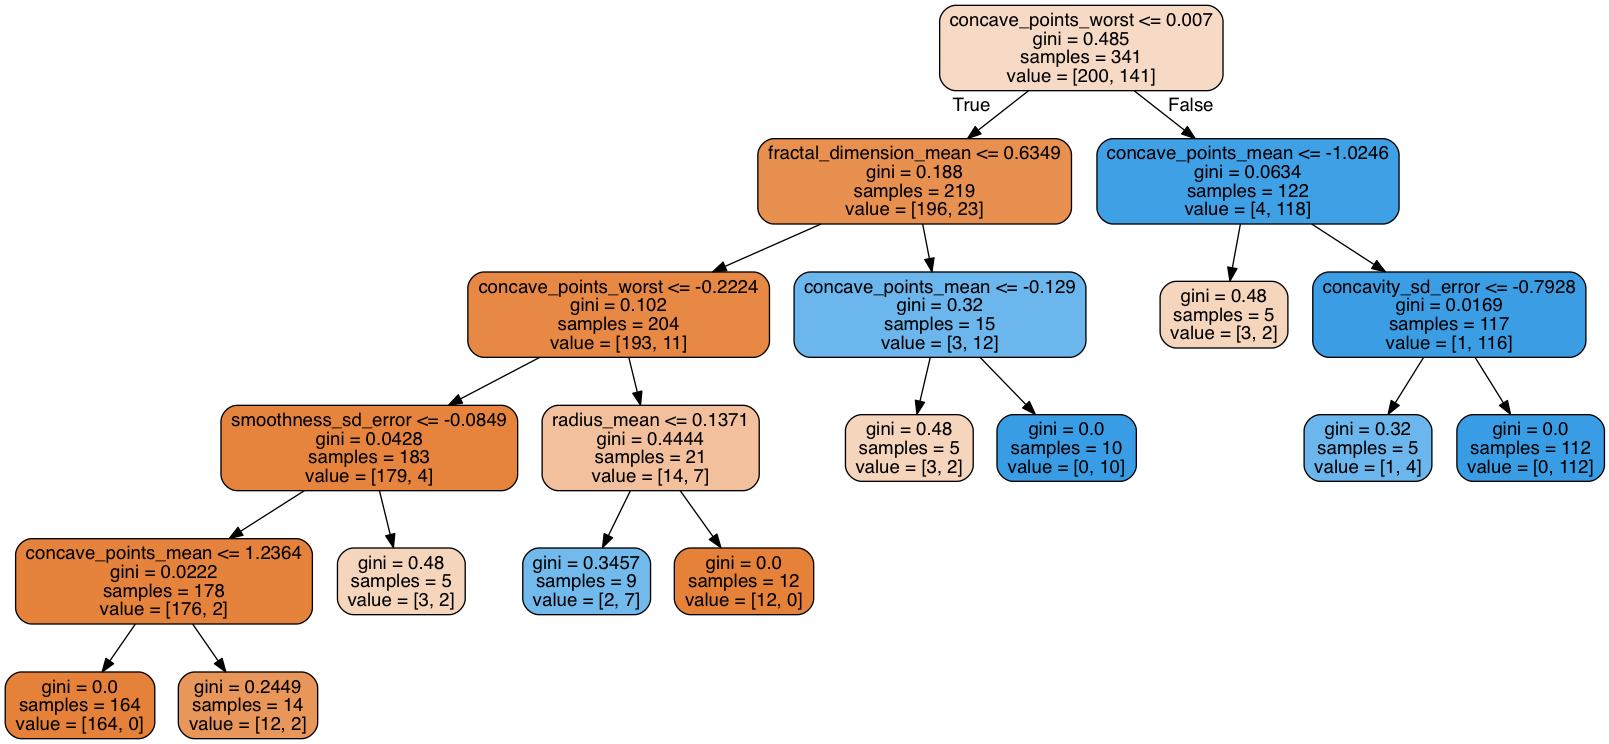

In [5]:
# visualize the classifier
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [6]:
# evaluate performance of single decision tree
print(metrics.classification_report(y_true=Y_test, y_pred=clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.95      0.92      0.94       157
          1       0.84      0.89      0.86        71

avg / total       0.91      0.91      0.91       228



In [7]:
# Adaptive Boosting from scratch

def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    
    # Initialize uniform weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specified weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        # Encode misclassifications as binary 0/1
        miss = [int(x) for x in (pred_train_i != Y_train)]
        
        # Encode misclassifications as 1/-1 to update weights (equivalent to above)
        miss2 = [x if x==1 else -1 for x in miss]
        
        # Compute weighted classification error
        err_m = np.dot(w,miss) / sum(w)
        
        # Compute new weights, alpha
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    return pred_train, pred_test

In [8]:
_, y_hat = adaboost_clf(Y_train, X_train, Y_test, X_test, M=5, clf=tree.DecisionTreeClassifier(min_samples_leaf=5))
print(metrics.classification_report(y_true=Y_test, y_pred=y_hat))

             precision    recall  f1-score   support

          0       1.00      0.69      0.82       157
          1       0.60      1.00      0.75        71

avg / total       0.87      0.79      0.80       228



**Notes**: 
* For M=1 (e.g. an ensemble of 1), we get back the same accuracy as the original classification tree!
* Accuracy metrics:
    * `Precision` is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    * `Recall` is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
    * `F-beta score` can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
    * `Support` is the number of occurrences of each class in y_true.

In [9]:
# Finally, let's use the fully-implimented version from scikit-learn
clf = ensemble.AdaBoostClassifier(learning_rate=1, n_estimators=50)
clf.fit(X_train, Y_train)
print(metrics.classification_report(y_true=Y_test, y_pred=clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.95      0.96       157
          1       0.89      0.94      0.92        71

avg / total       0.95      0.95      0.95       228



## Gradient Boosting From Scratch

In [10]:
df = pd.read_csv('Gradient_boosting_example_data.csv', index_col='PersonID')
features = ['LikesGardening', 'PlaysVideoGames', 'LikesHats']
predictand = 'Age'
X = df[features]
y = df[predictand]

print(df)

          Age  LikesGardening  PlaysVideoGames  LikesHats
PersonID                                                 
1          13           False             True       True
2          14           False             True      False
3          15           False             True      False
4          25            True             True       True
5          35           False             True       True
6          49            True            False      False
7          68            True             True       True
8          71            True            False      False
9          73            True            False       True


In [11]:
# decision tree depth-1 (stump) implimentation from first principles
for feature in X.columns:
    feature_means = df.groupby([feature])[predictand].mean()
    prediction_colname = 'stump_prediction_{}'.format(feature)
    residual_colname = 'stump_residual_{}'.format(feature)
    for index, value in enumerate(df[feature]):
        index += 1 # zero indexing correction
        df.loc[index, prediction_colname] = feature_means[value]
        df.loc[index, residual_colname] = df.loc[index, predictand] - df.loc[index, prediction_colname]

print(df)

          Age  LikesGardening  PlaysVideoGames  LikesHats  \
PersonID                                                    
1          13           False             True       True   
2          14           False             True      False   
3          15           False             True      False   
4          25            True             True       True   
5          35           False             True       True   
6          49            True            False      False   
7          68            True             True       True   
8          71            True            False      False   
9          73            True            False       True   

          stump_prediction_LikesGardening  stump_residual_LikesGardening  \
PersonID                                                                   
1                                   19.25                          -6.25   
2                                   19.25                          -5.25   
3                       

In [12]:
# which stump produces the lowest residuals?
df.filter(regex='residual').apply(lambda resid: np.sqrt(np.sum((resid) ** 2))).sort_values()

stump_residual_LikesGardening     44.649188
stump_residual_PlaysVideoGames    51.009803
stump_residual_LikesHats          71.592947
dtype: float64

In [13]:
# second tree on the residuals of the first
predictand = 'stump_residual_LikesGardening'
for feature in X.columns:
    feature_means = df.groupby([feature])[predictand].mean()
    prediction_colname = 'second_prediction_{}'.format(feature)
    residual_colname = 'second_residual_{}'.format(feature)
    for index, value in enumerate(df[feature]):
        index += 1 # zero indexing correction
        df.loc[index, prediction_colname] = feature_means[value]
        df.loc[index, residual_colname] = df.loc[index, predictand] - df.loc[index, prediction_colname]

In [14]:
# which stump produces the lowest residuals?
df.filter(regex='second_residual').apply(lambda resid: np.sqrt(np.sum((resid) ** 2))).sort_values()

second_residual_PlaysVideoGames    42.006785
second_residual_LikesHats          44.572475
second_residual_LikesGardening     44.649188
dtype: float64

In [15]:
df['boosted_prediction'] = df.stump_prediction_LikesGardening + df.second_prediction_PlaysVideoGames
df['boosted_residuals'] = df.Age - df.boosted_prediction
summary = df[['Age', 'stump_prediction_LikesGardening', 'boosted_prediction']].apply(round)

In [16]:
print('mean square errors on stump prediction: {:.2f}'.format(metrics.mean_squared_error(df.stump_prediction_LikesGardening, df.Age)))
print('mean square errors on boosted prediction: {:.2f}'.format(metrics.mean_squared_error(df.boosted_prediction, df.Age)))

mean square errors on stump prediction: 221.51
mean square errors on boosted prediction: 196.06


In [17]:
# helper functions
def compute_gradient(prediction1, prediction2, target, loss_function):
    loss_function_gradient = loss_function(prediction2, target) - loss_function(prediction1, target)
    return loss_function_gradient

def rmse(y_hat, y_true, normalize=False):
    '''RMSE represents the sample standard deviation of the differences between predicted and observed values'''
    y_hat = _convert_to_1D_np_array(y_hat)
    y_true = _convert_to_1D_np_array(y_true)
    normalization = y_true.size if normalize else 1
    return np.sqrt(np.sum((y_hat - y_true) ** 2) / normalization)

def sse(y_hat, y_true):
    return np.sum((y_hat - y_true) ** 2)

def mean_absolute_deviation(y_hat, y_true):
    '''mean absolute deviation is approximately 0.798 x standard deviation for normally distributed random variables'''
    y_hat = _convert_to_1D_np_array(y_hat)
    y_true = _convert_to_1D_np_array(y_true)
    return np.mean(np.abs(y_hat - y_true))

def median_absolute_deviation(y_hat, y_true):
    '''median absolute deviation is approximately 0.675 x standard deviation for normally distributed random variables'''
    y_hat = _convert_to_1D_np_array(y_hat)
    y_true = _convert_to_1D_np_array(y_true)
    return np.median(np.abs(y_hat - y_true))

def symmetric_mean_absolute_percent_error(y_hat, y_true):
    '''SMAPE is bound between 0 and 200%'''
    y_hat = _convert_to_1D_np_array(y_hat)
    y_true = _convert_to_1D_np_array(y_true)
    return np.sum(np.abs(y_hat - y_true) / ((np.abs(y_true) + np.abs(y_hat)) / 2.0)) * (100.0 / y_true.size)

def standardize(y):
    y = _convert_to_1D_np_array(y)
    return (y - np.mean(y)) / np.std(y)

def mean_absolute_scaled_error(y_hat, y_true):
    '''MASE from Hyndman and Koehler'''
    y_hat = _convert_to_1D_np_array(y_hat)
    y_true = _convert_to_1D_np_array(y_true)
    denom_sum = np.sum(abs(y_true[1:] - y_true[:-1]))
    error = abs(y_true - y_hat)
    denom = denom_sum / (float(len(y_hat)) - 1)
    return np.mean(error / denom)

def _convert_to_1D_np_array(y):
    if isinstance(y, (int, float, list)):
        return np.array(y)
    elif isinstance(y, pd.Series):
        return np.array(y)
    elif isinstance(y, pd.DataFrame):
        if y.shape[1] > 1:
            raise Exception('y must be 1-dimensional')
        else:
            return np.array(y.ix[:, 0])
    elif isinstance(y, np.ndarray):
        if y.ndim > 1:
            raise Exception('y must be 1-dimensional')
        else:
            return y
    else:
        raise Exception('y must be of type int, float, long or a 1-dimensional array-like object')


In [18]:
ytrue = [13, 25]
yhat1 = [35, 35]
improvement = -1
yhat2 = [item + improvement for item in yhat1]

gradient_descent_1 = compute_gradient(yhat1[0], yhat2[0], ytrue[0], loss_function=sse)
gradient_descent_2 = compute_gradient(yhat1[1], yhat2[1], ytrue[1], loss_function=sse)
print(gradient_descent_1, gradient_descent_2)

-43 -19


In [19]:
gradient_descent_1 = compute_gradient(yhat1[0], yhat2[0], ytrue[0], median_absolute_deviation)
gradient_descent_2 = compute_gradient(yhat1[1], yhat2[1], ytrue[1], median_absolute_deviation)
print(gradient_descent_1, gradient_descent_2)

-1.0 -1.0


Note: Gradient Boosted Trees are sensitive to the loss function! 